# AMN-resevoir to improve cobra prediction

Here we attempt to improve the prediction of cobra solver on experimental data. The input commonly used in cobra is the concentration of compounds in the media, as an approximation of uptake fluxes of metabolism. We try here to improve the prediction of cobra here by finding a more accurate uptake fluxes estimation.
We use an AMNWt model, trained on data simulated by cobra to mimic the behavior of cobra. All weight of this model are freezed after training. A part of the input fluxes is considered as essential in medium to obtain growth remains unchanged but the rest of the input is given to a dense layer. A new model is the chaining of the couple [identity, dense layer] and of the pre-trained AMNWt model. This new model is then trained on all the experimental dataset. The output of the trained couple [identity, dense layer] is then given a input layer for cobra model.

We use this idea on two pair of dataset. First on e_coli, we use iML1515_UB as simulated dataset and iML1515_EXP_UB as experimental dataset. Then on P.putida, we use IJN1463_10_UB as simulated dataset and IJN1463_EXP_UB_Anne.

In [57]:
# E_coli with iML1515 
dataset_file_simulated = "/Dataset/iML1515_UB.npz"
dataset_file_experimental = "/Dataset/iML1515_EXP_UB.npz"
objective = ["BIOMASS_Ec_iML1515_core_75p37M"]

pretrained_model_name = "AMNWt_iML1515_UB.keras"
cobra_model_file = "/Dataset/iML1515_EXP_UB.xml"

batch_size = 7
epochs = 100 
seed = 10

essential_medium_size = 28
essential_medium_level = 2.2
hidden_layer_size = 500

plot_figure_regression = "figures_reservoir/reservoir_iML1515_UB.png"
plot_figure_classification = ""

In [44]:
# P.putida with IJN1463
dataset_file_simulated = "/Dataset/IJN1463_10_UB.npz"
dataset_file_experimental = "/Dataset/IJN1463_EXP_UB.npz"
objective = ["BIOMASS_KT2440_WT3"]

pretrained_model_name = "AMNWt_IJN1463_10_UB.keras"
cobra_model_file = "/Dataset/IJN1463_EXP_UB.xml"

batch_size = 7
epochs = 20
seed = 10

essential_medium_size = 23
essential_medium_level = 10
hidden_layer_size = 500

plot_figure_regression = ""
plot_figure_classification = "figures_reservoir/reservoir_IJN1463_10.png"
plot_figure_accuracies = "figures_reservoir/reservoir_accuracy_all_carbon_nitrogen.png"


In [58]:
model_dir = "../models/"
model_file_simulated = model_dir + pretrained_model_name

# Unzip the model files
# from amn.tools import unzip_folders
# unzip_folders(model_dir)

## Load the experimental and simulated datasets

In [59]:
import tensorflow as tf
from amn.model.aMNWtModel import AMNWtModel

tf.random.set_seed(seed)
data_dir = "../data"

model_simulated = AMNWtModel(dataset_file=data_dir + dataset_file_simulated, 
                   objective=objective,
                   timestep=4,
                   hidden_dim=50,
                   verbose=True,
                   )

model_simulated.train_test_split(test_size=0.1, random_state=seed)
model_simulated.preprocessing_for_specific_model()


model_experimental = AMNWtModel(dataset_file=data_dir + dataset_file_experimental, 
                   objective=objective,
                   timestep=4,
                   hidden_dim=50,
                   verbose=True,
                   )

model_experimental.train_test_split(test_size=0.1, random_state=seed)
model_experimental.preprocessing_for_specific_model()

number of metabolites:  1877
filtered measurements size:  1
number of metabolites:  1080
filtered measurements size:  1


## Load the pre-trained model on simulated dataset

In [60]:
from amn.model.aMNWtModel import RNNCell
from amn.tools import custom_loss

loss = custom_loss(model_simulated.S, model_simulated.P_out, model_simulated.P_in)

AMNWt_model = tf.keras.models.load_model(model_file_simulated, 
                                          custom_objects={"RNNCell":RNNCell,
                                                          "my_mse":custom_loss(model_simulated.S, 
                                                                               model_simulated.P_out,
                                                                               model_simulated.P_in)}
                                          )

print("R2 :", model_simulated.R2(model_simulated.Y_train, AMNWt_model.predict(model_simulated.X_train)))
print("Q2 :", model_simulated.R2(model_simulated.Y_test, AMNWt_model.predict(model_simulated.X_test)))

R2 : 0.9993539978754362
Q2 : 0.9996111356698927


## Add a layer to old pre-trained model and fix model weights

In [61]:
from tensorflow.keras import Model, Input, layers

# Different layer of new model
AMNWt_model.trainable = False
layer_1 = layers.Dense(hidden_layer_size,
                     activation='relu')
layer_2 = layers.Dense(model_experimental.X.shape[1] - essential_medium_size,
                     activation='relu')

# split intput
inputs = Input((model_experimental.X.shape[1]))
input_dense = inputs[:,essential_medium_size:]  
input_fixed = inputs[:,:essential_medium_size]

# create the new model
x = layer_2(layer_1(input_dense))
y = AMNWt_model(tf.concat([input_fixed, x],1))

new_model = Model(inputs=inputs, 
                  outputs=y)

new_model.compile(optimizer='adam',
              loss=loss,
              metrics=None)

## Train new model on all experimental dataset

In [62]:
import numpy as np
from amn.visualize import plot_regression

# Train the new model
X = model_experimental.X * essential_medium_level
Y = np.concatenate((model_experimental.Y, np.zeros((len(model_experimental.Y),3))), axis=1)
history = new_model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=0)

# Use it to predict all fluxes
pred_all = new_model.predict(X)
R_2 = model_simulated.R2(Y, pred_all)
print("R² = ", R_2)

# Results
pred_growth_rate = tf.linalg.matmul(pred_all[:,:model_simulated.S.shape[1]], 
                        tf.transpose(np.float32(model_simulated.P_out))) 
true_growth_rate = Y[:,0]

R² =  0.9990859243317387


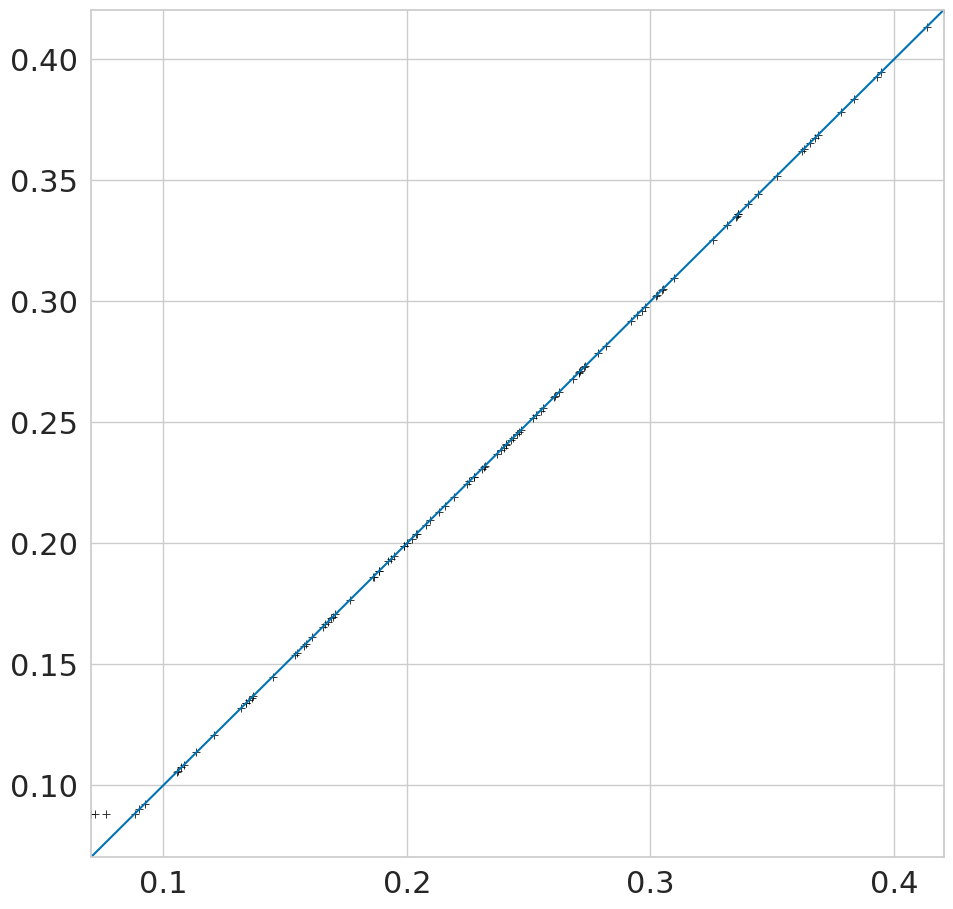

In [63]:
plot_regression(pred=pred_growth_rate,
                true=true_growth_rate,
                pred_label="",
                true_label="",
                title="",
                saving_file=None,
                show=True)

## Using cobra with output of the new_model as input

In [64]:
# Split the input
X_dense = X[:,essential_medium_size:]  
X_fixed = X[:,:essential_medium_size]

# Use the dense layers to get the input fluxes for cobra
x_output_dense = layer_2(layer_1(X_dense))
V_in = tf.concat([X_fixed, x_output_dense],1)

In [65]:
import cobra
from sklearn.metrics import r2_score
from amn.run_cobra import run_cobra



cobra_model = cobra.io.read_sbml_model(data_dir + cobra_model_file)

pred_cobra = []
for i in range(V_in.shape[0]):
    # Initialize all the reaction to 0
    inf = {r.id: 0 for r in cobra_model.reactions}
    # Add all the non-nul inputs for the entry i
    for j in range(V_in.shape[1]):
        inf[model_simulated.medium[j]] = float(V_in[i,j]) 
    result = run_cobra(cobra_model,objective,inf)

    pred_cobra.append(result[1])



### Regression

R² =  0.9992322514798075


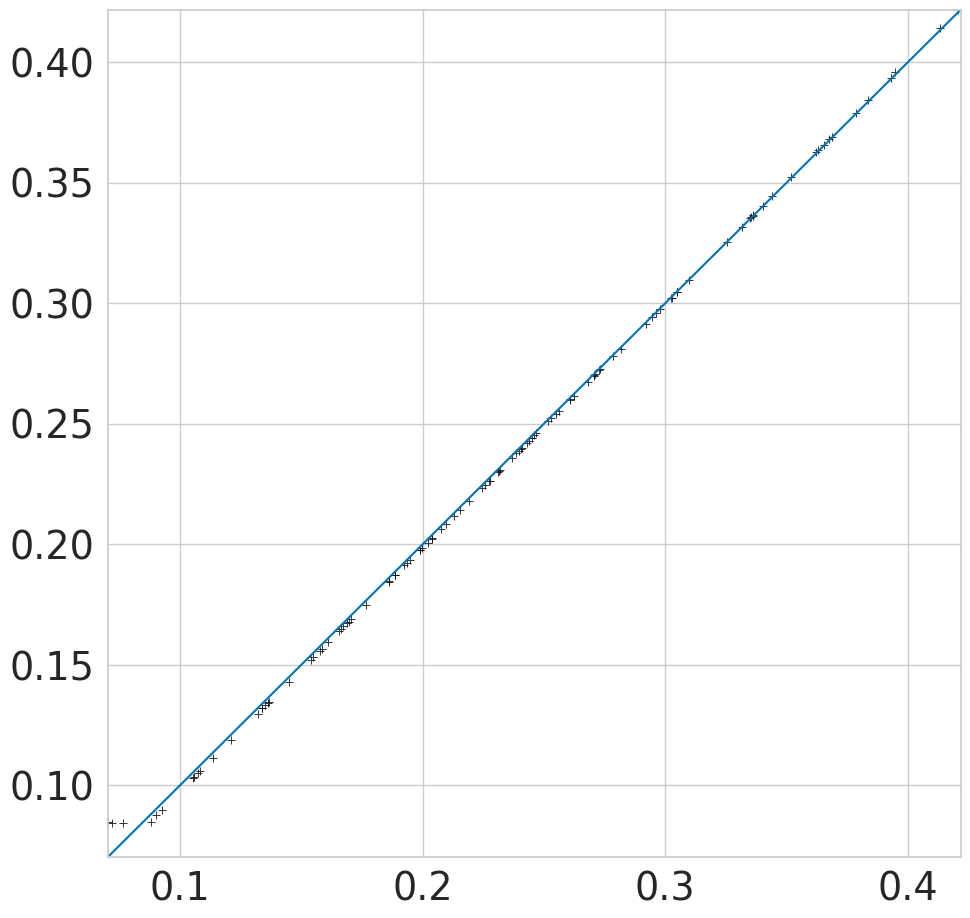

In [66]:
# Results
R_2 = r2_score(true_growth_rate, pred_cobra)
print("R² = ", R_2)
plot_regression(pred=pred_cobra,
                true=true_growth_rate,
                pred_label="",
                true_label="",
                title="",
                saving_file=plot_figure_regression,
                show=True)

### Classification (putida only)

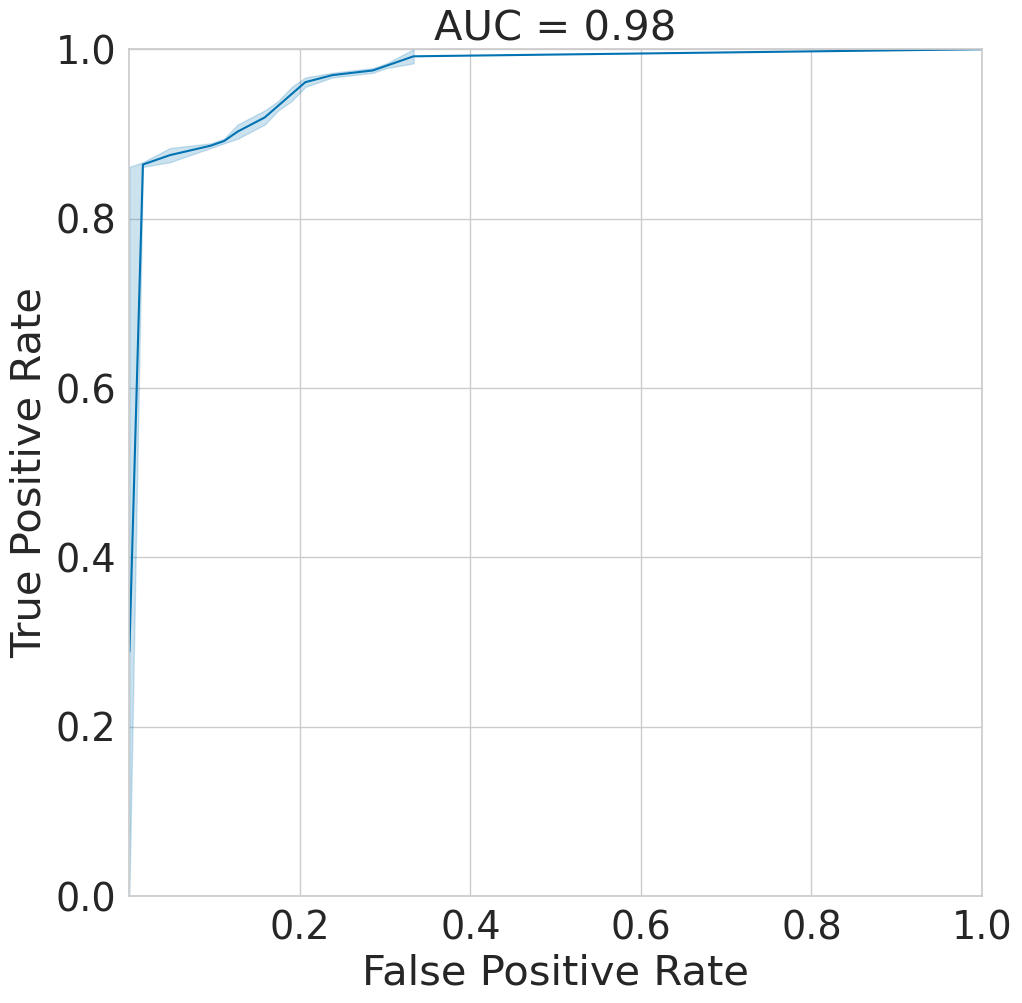

In [54]:
from amn.visualize import plot_classification
plot_classification(pred=pred_cobra,
                    true=true_growth_rate,
                    saving_file=plot_figure_classification,
                    show=True)



The original dataset of Putida comes originally from the article : *High-quality genome-scale metabolic modelling of Pseudomonas putida highlights its broad metabolic capabilities. Nogales, J. et al., Environ. Microbiol. 22, 255–269 (2020).*

In this article they explore alternative sources of carbon and nitrogen, testing the growth/no growth. The accuracy is then computed on all the dataset, and on the part of the dataset where they explores alternative source for carbon (resp. nitrogen).

In [55]:
from sklearn.metrics import accuracy_score
from amn.tools import threshold_percentage_max

# Finding nitrogen and carbon alternative source testing
X_nitrogen = X[:,22] == 0 
X_carbon = X[:,15] == 0
nitrogen_index = [i for (i, bool) in enumerate(X_nitrogen) if bool]
carbon_index = [i for (i, bool) in enumerate(X_carbon) if bool]

# Threshold cobra prediction to obtain binary vector 
pred_cobra_binary = threshold_percentage_max(np.array(pred_cobra), 0.3)

all_accuracy = accuracy_score(pred_cobra_binary, true_growth_rate)
carbon_accuracy = accuracy_score(pred_cobra_binary[carbon_index] , true_growth_rate[carbon_index])
nitrogen_accuracy = accuracy_score(pred_cobra_binary[nitrogen_index] , true_growth_rate[nitrogen_index])

[0.9053497942386831, 0.922077922077922, 0.8963414634146342]


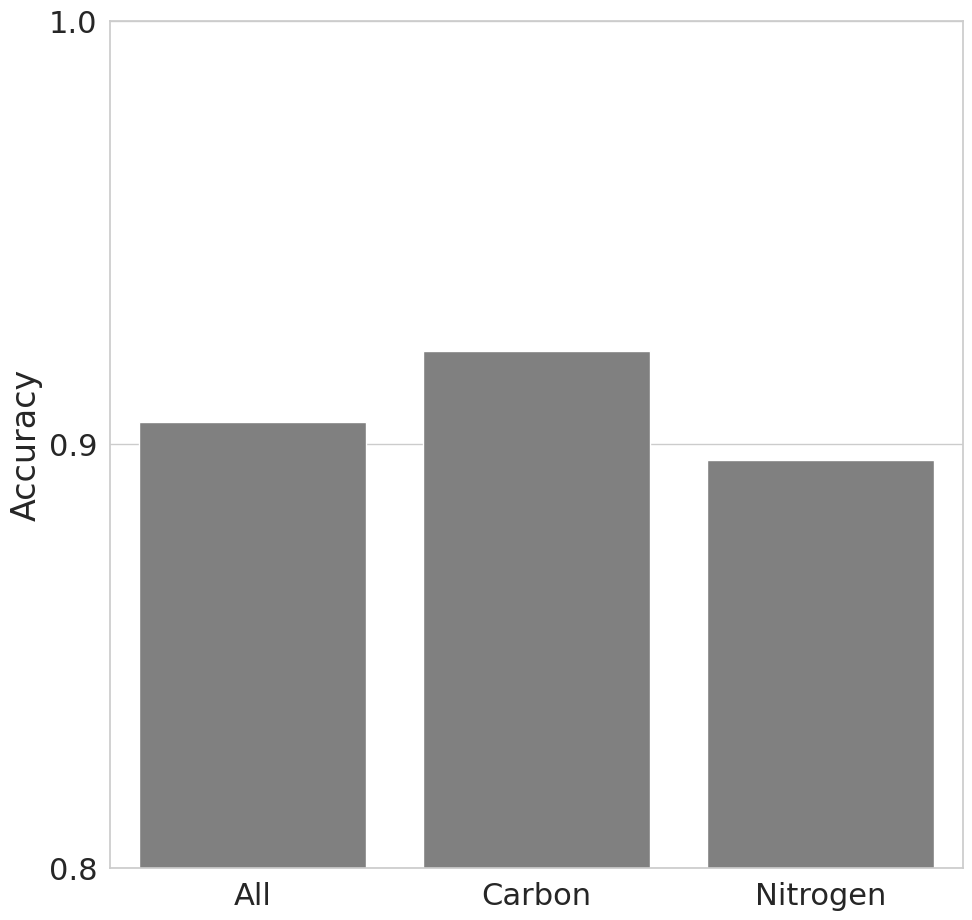

In [56]:
from amn.visualize import plot_accuracies

condition = ["All", "Carbon", "Nitrogen"]
acc_fit_AMN = [all_accuracy, carbon_accuracy, nitrogen_accuracy]
print(acc_fit_AMN)
plot_accuracies(acc_fit_AMN, condition, save_file=plot_figure_accuracies)